# Finding Lane Lines Project

## Setup
We'll begin by importing the required libraries

In [364]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pipline Overview

1. load an image (or video frame)
2. convert to grayscale (to avoid pitfall of non-white color lane-lines)
3. perform canny edge detection
4. remove everything outside region of interest
5. perform the Hough transform to detect lines 
6. average out and extrapolate the lines (lane lines are detected as double, parallel, segments (edges) - combine them into single lines, stretch to the horizon the image)
7. overlay the average lines image untop the original image/frame

## Pipeline Methods

In [404]:
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def edge_detect(img):
    return cv2.Canny(img,150,300)


def extract_roi(img):
    height, width = img.shape
    width -= 1
    height -= 1 
    # define region of interest
    verts = np.array([[0,height],[width/2,height/2], [width, height],[0,height]], dtype=np.int32)
    # define extraction mask
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [verts],255)
    # extract region of interest and return
    return cv2.bitwise_and(img, mask)
    
def hough_line_detect(img):
    # utilize probabilistic Hough line transform to detect lane lines  
    return cv2.HoughLinesP(edges, rho=1,theta=np.pi/180 , threshold=70,
                            minLineLength=60, maxLineGap=20)

def line_avg_and_extrapolate(lines):
    # these will be used to calc left lane
    left_slope = 0
    left_offset = 0
    left_count = 0
    
    # these will be used to calc right lane
    right_slope = 0 
    right_offset = 0
    right_count = 0
    
    # handle empty case
    if lines is None:
        return np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # aggeragate slope and offset values
    for line in lines:
        # check if it's empty
        x1,y1,x2,y2 = line[0]

        # calc deltas
        dx = x1-x2
        dy = y1-y2

        # avoid division by zero
        if dx == 0:
            continue

        # calc slope and add to avg
        slope = dy/dx

        if slope<0:
            left_slope += slope
            left_offset += y1- slope*x1
            left_count += 1
        elif slope>0:
            right_slope += slope
            right_offset += y1- slope*x1
            right_count += 1
    
    if left_count == 0 or right_count == 0:
        return np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # average out to get the left lane line
    left_slope = left_slope/left_count
    left_offset = left_offset/left_count
    
    
    # average out to get the right lane line
    right_slope = right_slope/right_count
    right_offset = right_offset/right_count

    # calculate bottom points lines
    right_bottom = (int((height-1-right_offset)/right_slope),height-1)
    left_bottom = (int((height-1-left_offset)/left_slope),height-1)

    # calculate the intersection point of left and right lines
    horizon_x =  int((right_offset-left_offset)/(left_slope-right_slope))
    horizon_y = int(right_slope*horizon_x+right_offset)
    horizon = (horizon_x, horizon_y)

    # create a new image black image to draw lines on
    lane_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    # draw the lines 
    cv2.line(lane_img,left_bottom,horizon,(255,50,50),11)
    cv2.line(lane_img,right_bottom,horizon,(255,50,50),11)

    return lane_img


def overlay_img(img, lane_img):
    return cv2.addWeighted(img, 1.0, lane_img, 0.50, 0.0)


def process_img(color_img):
        grayscale_img = to_grayscale(color_img)
        edges = edge_detect(grayscale_img)
        roi_edges = extract_roi(edges)
        lines = hough_line_detect(roi_edges)
        avg_extrp_line_img = line_avg_and_extrapolate(lines)
        overlaid_img = overlay_img(color_img, avg_extrp_line_img)
        return overlaid_img
    

### Pipeline Image Demo

* load a test image and convert to grayscale via opencv 

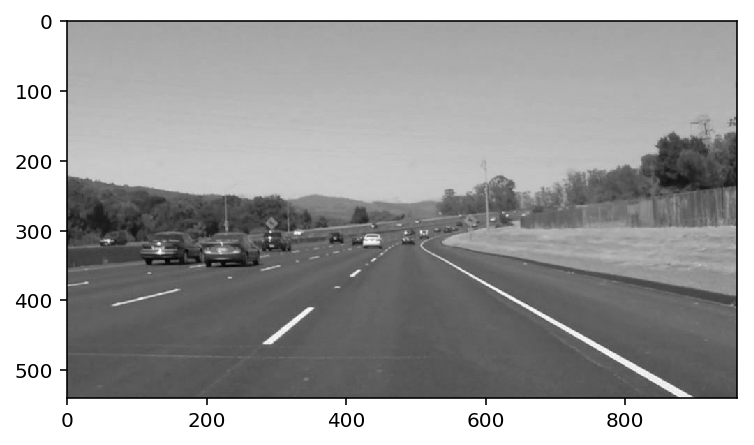

In [379]:
color_img = cv2.imread('./test_images/solidWhiteCurve.jpg')
img = to_grayscale(color_img)
plt.imshow(img, cmap='gray')

* perform canny edge detection (again via opencv)

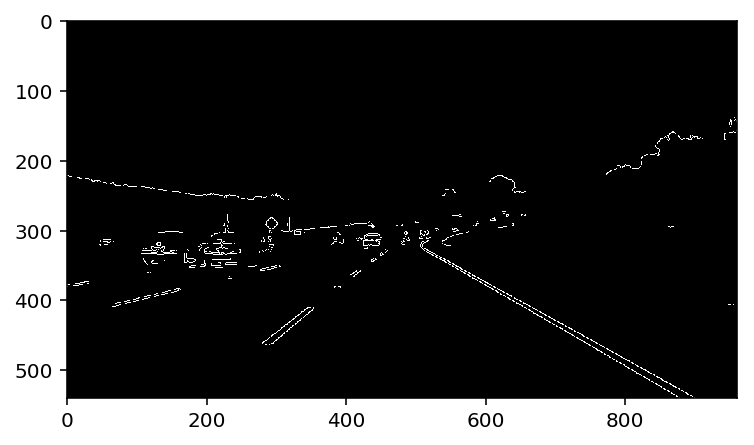

In [380]:
edges = edge_detect(img)
plt.imshow(edges, cmap='gray')

* mark region of interest in an image dimension independent way (naive)

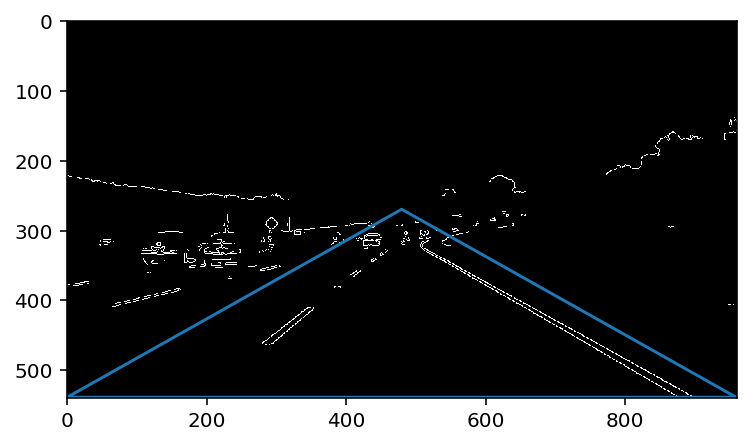

In [381]:
# get image dimensions
height, width = edges.shape
width -= 1
height -= 1 

# define region of interest
verts = [[0,height],
         [width/2,height/2], 
         [width, height],[0,height]]

# create lists of x and y values
xs, ys = zip(*verts)
# draw the image
plt.imshow(edges, cmap='gray')
# plot the polygon on top 
plt.plot(xs,ys) 


* remove everything outside region of interest

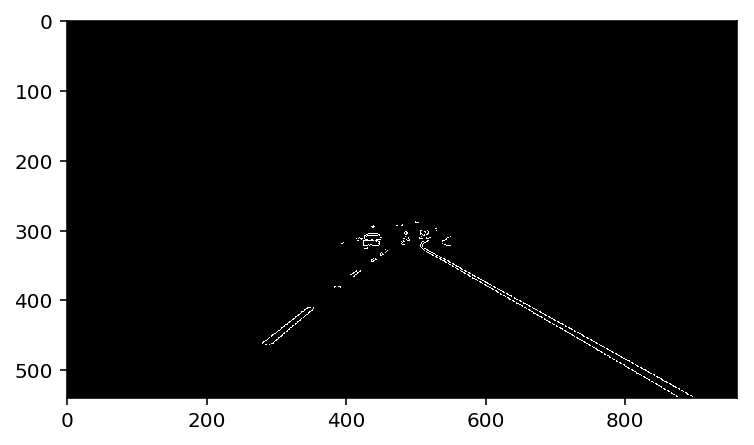

In [382]:
edges = extract_roi(edges)
plt.imshow(edges,cmap='gray')

* perform Hough transform

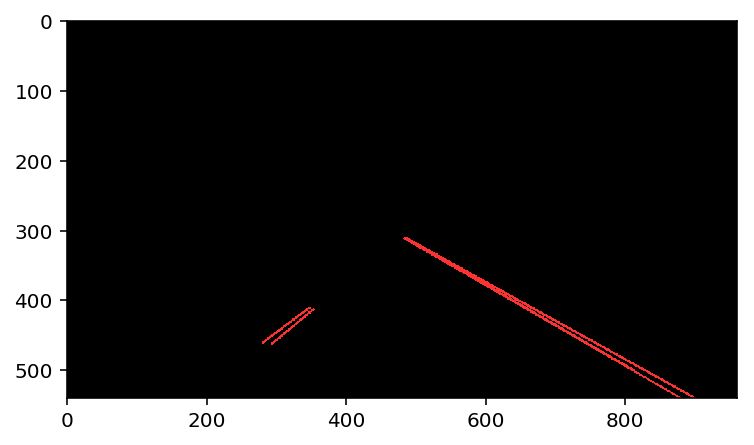

In [403]:
# utilize probabilistic Hough line transform to detect lane lines  
lines = cv2.HoughLinesP(edges, rho=1,theta=np.pi/180 , threshold=70,
                            minLineLength=60, maxLineGap=20)

# create an empty image to draw the lines on
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

# draw the detected lines
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img,(x1,y1),(x2,y2),(255,50,50),2)
        
plt.imshow(line_img)

* average and extrapolate lines

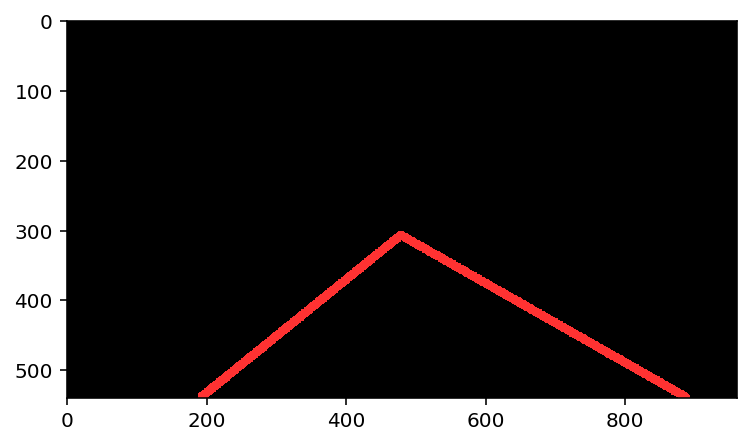

In [394]:
lane_img = line_avg_and_extrapolate(lines)

plt.imshow(lane_img)

* overlay averaged lines unto the original image with some transparaency

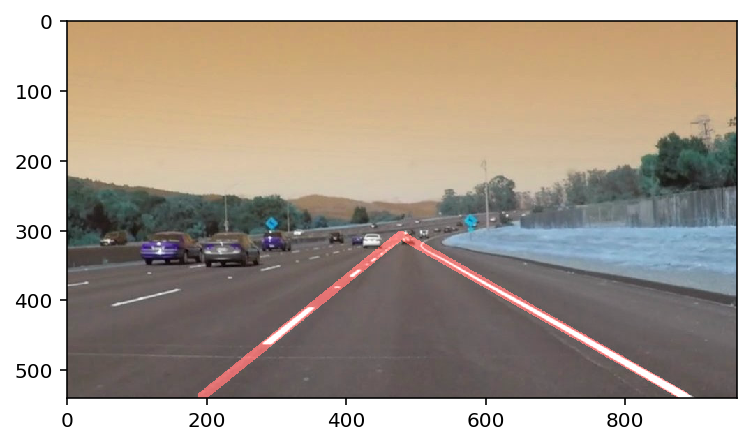

In [395]:
# overlay the empty image with the lines unto the original image with some alpha transparency
output_img= overlay_img(color_img,lane_img)
plt.imshow(output_img)

## Video Pipeline Demo

### Overview

### Methods

In [397]:
def process_video(video_input, video_output):

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(process_img)
    processed.write_videofile(os.path.join('output_videos', video_output), audio=False)

### Test White

In [405]:
%time process_video('solidWhiteRight.mp4', 'white.mp4')

[MoviePy] >>>> Building video output_videos/white.mp4
[MoviePy] Writing video output_videos/white.mp4



100%|█████████▉| 221/222 [00:03<00:00, 69.24it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/white.mp4 

CPU times: user 3.08 s, sys: 630 ms, total: 3.71 s
Wall time: 3.87 s


In [406]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_videos/white.mp4'))

### Test Yellow

In [407]:
%time process_video('solidYellowLeft.mp4', 'yellow.mp4')

[MoviePy] >>>> Building video output_videos/yellow.mp4
[MoviePy] Writing video output_videos/yellow.mp4



100%|█████████▉| 681/682 [00:09<00:00, 72.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/yellow.mp4 

CPU times: user 9.36 s, sys: 1.66 s, total: 11 s
Wall time: 10.2 s


In [408]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_videos/yellow.mp4'))

### Test Challenge

In [410]:
%time process_video('challenge.mp4', 'challenge.mp4')

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/core/src/arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op
